In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

In [8]:
df = yf.download("TCS.NS", start="2018-01-01", end="2024-12-31")
data = df[['Close']].dropna()

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

[*********************100%***********************]  1 of 1 completed


In [9]:
# ARIMA Model
arima_model = ARIMA(train, order=(5,1,2))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

# LSTM Model
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


c:\Users\NEEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NEEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NEEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NEEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availab

In [10]:
X, y = [], []
window = 60

for i in range(window, len(scaled_data)):
    X.append(scaled_data[i-window:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test = X[:train_size-window], X[train_size-window:]
y_train, y_test = y[:train_size-window], y[train_size-window:]

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

Epoch 1/50


c:\Users\NEEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0396
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.2150e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.8023e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.1478e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.5668e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.3790e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.3811e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.4373e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.7348e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.0892e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.0451e-04
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.1227e-04
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.6429e-04
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━

In [11]:
arima_rmse = math.sqrt(mean_squared_error(test.values, arima_pred))
lstm_rmse = math.sqrt(mean_squared_error(y_test_real, lstm_pred))

print(f"ARIMA RMSE (INR): {arima_rmse:.2f}")
print(f"LSTM RMSE (INR): {lstm_rmse:.2f}")

ARIMA RMSE (INR): 589.40
LSTM RMSE (INR): 74.20


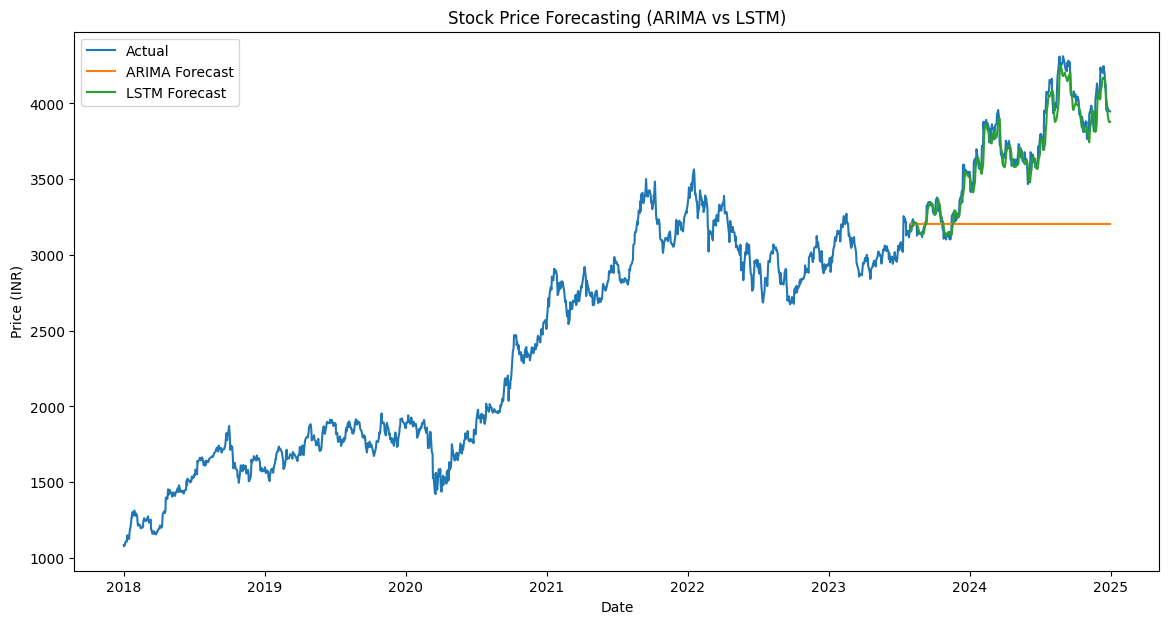

In [12]:

plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close'], label="Actual")
plt.plot(test.index, arima_pred, label="ARIMA Forecast")
plt.plot(test.index, lstm_pred, label="LSTM Forecast")
plt.legend()
plt.title("Stock Price Forecasting (ARIMA vs LSTM)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.show()

**ARIMA forecasts tend to converge toward the series mean (or linear trend) for long horizons due to its linear structure, while LSTMs can learn complex nonlinear patterns and long-term dependencies from data, allowing them to model trends and other structures more flexibly.**